# Visualization with Seaborn

Matplotlib has been at the core of scientific visualization in Python for decades, but even avid users will admit it often leaves much to be desired.
There are several complaints about Matplotlib that often come up:

- A common early complaint, which is now outdated: prior to version 2.0, Matplotlib's color and style defaults were at times poor and looked dated.
- Matplotlib's API is relatively low-level. Doing sophisticated statistical visualization is possible, but often requires a *lot* of boilerplate code.
- Matplotlib predated Pandas by more than a decade, and thus is not designed for use with Pandas `DataFrame` objects. In order to visualize data from a `DataFrame`, you must extract each `Series` and often concatenate them together into the right format. It would be nicer to have a plotting library that can intelligently use the `DataFrame` labels in a plot.

An answer to these problems is [Seaborn](http://seaborn.pydata.org/). Seaborn provides an API on top of Matplotlib that offers sane choices for plot style and color defaults, defines simple high-level functions for common statistical plot types, and integrates with the functionality provided by Pandas.

To be fair, the Matplotlib team has adapted to the changing landscape: it added the `plt.style` tools discussed in [Customizing Matplotlib: Configurations and Style Sheets](04.11-Settings-and-Stylesheets.ipynb), and Matplotlib is starting to handle Pandas data more seamlessly.
But for all the reasons just discussed, Seaborn remains a useful add-on.

By convention, Seaborn is often imported as `sns`:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()  # seaborn's method to set its chart style

## Exploring Seaborn Plots

The main idea of Seaborn is that it provides high-level commands to create a variety of plot types useful for statistical data exploration, and even some statistical model fitting.

Let's take a look at a few of the datasets and plot types available in Seaborn. Note that all of the following *could* be done using raw Matplotlib commands (this is, in fact, what Seaborn does under the hood), but the Seaborn API is much more convenient.

### Histograms, KDE, and Densities

Often in statistical data visualization, all you want is to plot histograms and joint distributions of variables.
We have seen that this is relatively straightforward in Matplotlib (see the following figure):

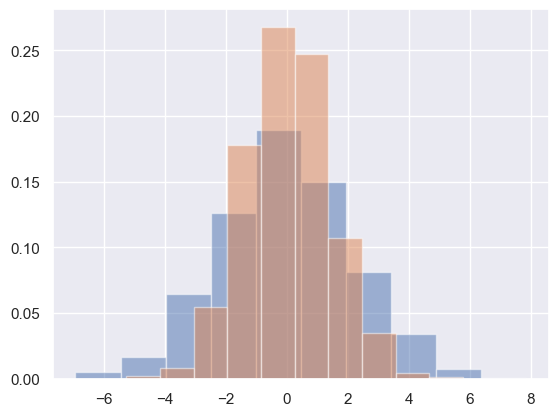

In [2]:
data = np.random.multivariate_normal([0, 0], [[5, 2], [2, 2]], size=2000)
data = pd.DataFrame(data, columns=['x', 'y'])

for col in 'xy':
    plt.hist(data[col], density=True, alpha=0.5)

Rather than just providing a histogram as a visual output, we can get a smooth estimate of the distribution using kernel density estimation (introduced in [Density and Contour Plots](04.04-Density-and-Contour-Plots.ipynb)), which Seaborn does with ``sns.kdeplot`` (see the following figure):

C:\Users\Micha\AppData\Local\Temp\ipykernel_26916\2427864141.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, shade=True);


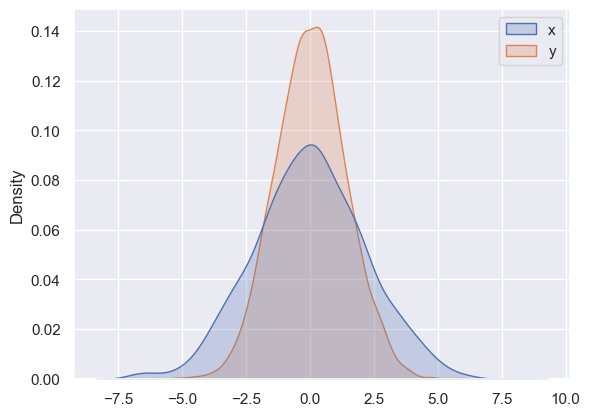

In [3]:
sns.kdeplot(data=data, shade=True);

If we pass `x` and `y` columns to `kdeplot`, we instead get a two-dimensional visualization of the joint density (see the following figure):

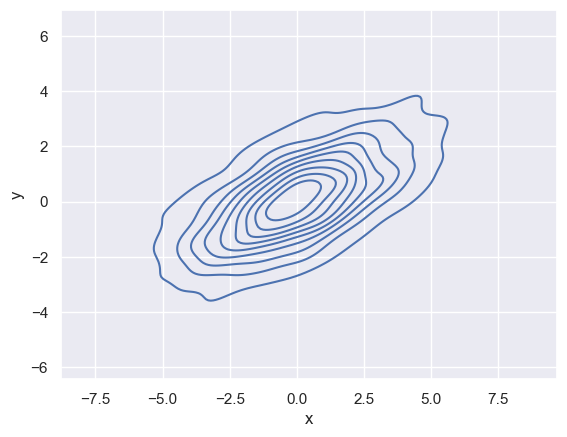

In [4]:
sns.kdeplot(data=data, x='x', y='y');

We can see the joint distribution and the marginal distributions together using `sns.jointplot`, which we'll explore further later in this chapter.

### Pair Plots

When you generalize joint plots to datasets of larger dimensions, you end up with *pair plots*. These are very useful for exploring correlations between multidimensional data, when you'd like to plot all pairs of values against each other.

We'll demo this with the well-known Iris dataset, which lists measurements of petals and sepals of three Iris species:

In [5]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Visualizing the multidimensional relationships among the samples is as easy as calling ``sns.pairplot`` (see the following figure):

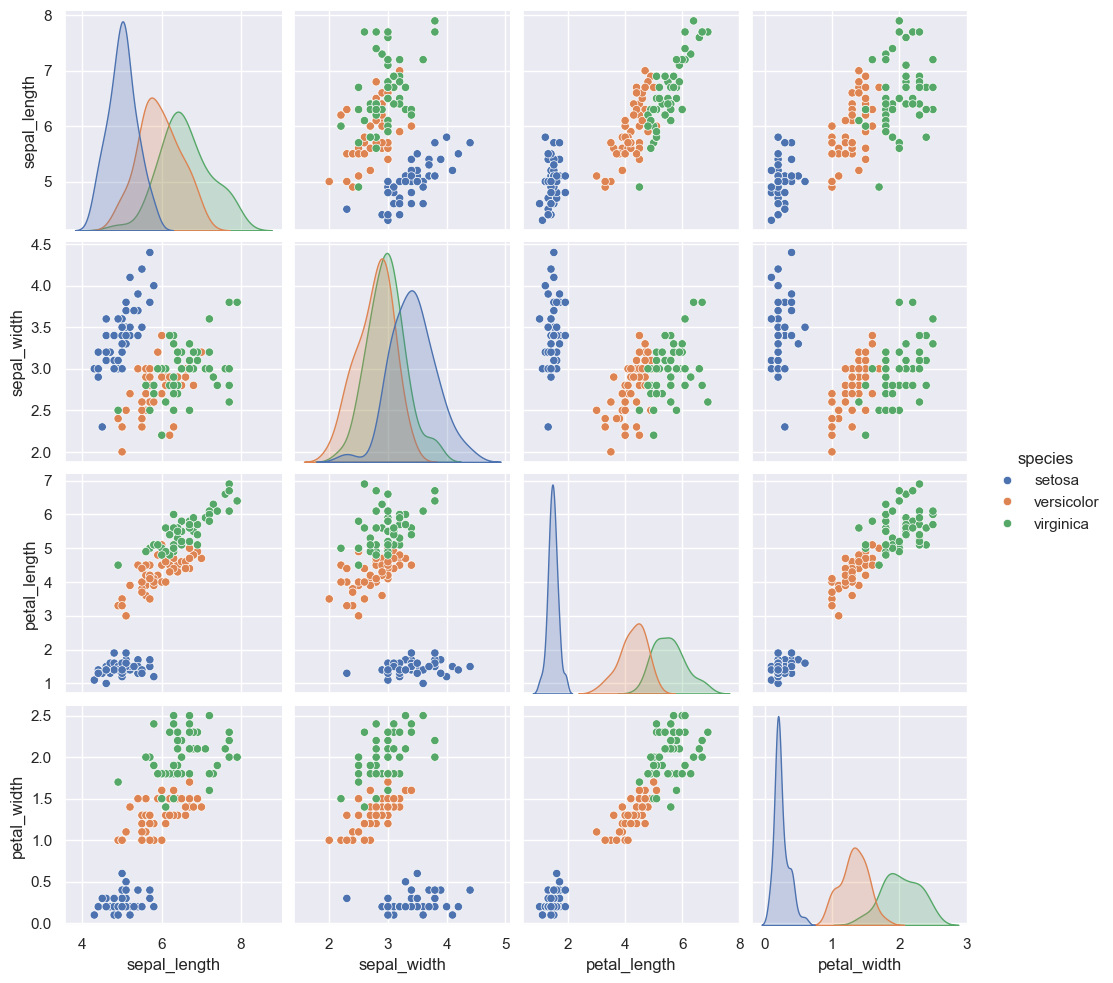

In [6]:
sns.pairplot(iris, hue='species', height=2.5);

### Faceted Histograms

Sometimes the best way to view data is via histograms of subsets, as shown in the following figure. Seaborn's `FacetGrid` makes this simple.
We'll take a look at some data that shows the amount that restaurant staff receive in tips based on various indicator data:[^1]

[^1]: The restaurant staff data used in this section divides employees into two sexes: female and male. Biological sex
isn’t binary, but the following discussion and visualizations are limited by this data.

In [7]:
tips = sns.load_dataset('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


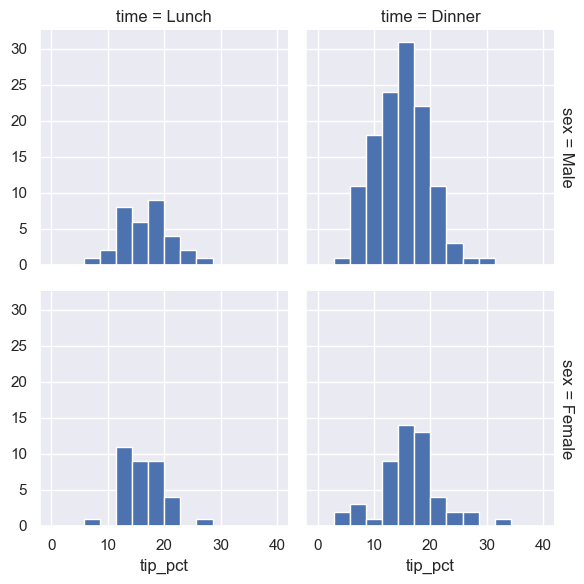

In [8]:
tips['tip_pct'] = 100 * tips['tip'] / tips['total_bill']

grid = sns.FacetGrid(tips, row="sex", col="time", margin_titles=True)
grid.map(plt.hist, "tip_pct", bins=np.linspace(0, 40, 15));

The faceted chart gives us some quick insights into the dataset: for example, we see that it contains far more data on male servers during the dinner hour than other categories, and typical tip amounts appear to range from approximately 10% to 20%, with some outliers on either end.

### Categorical Plots

Categorical plots can be useful for this kind of visualization as well. These allow you to view the distribution of a parameter within bins defined by any other parameter, as shown in the following figure:

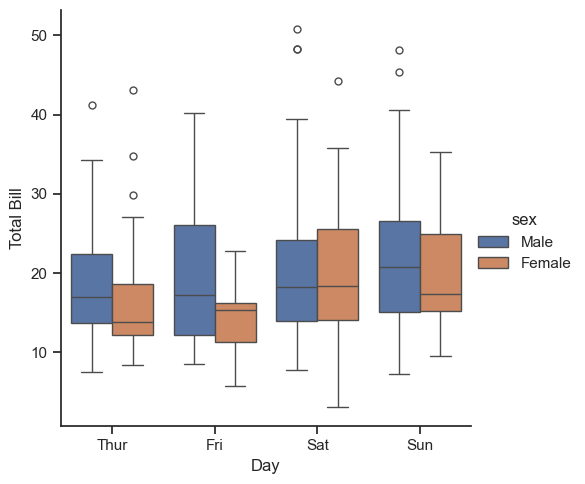

In [9]:
with sns.axes_style(style='ticks'):
    g = sns.catplot(x="day", y="total_bill", hue="sex", data=tips, kind="box")
    g.set_axis_labels("Day", "Total Bill");

### Joint Distributions

Similar to the pair plot we saw earlier, we can use `sns.jointplot` to show the joint distribution between different datasets, along with the associated marginal distributions (see the following figure):

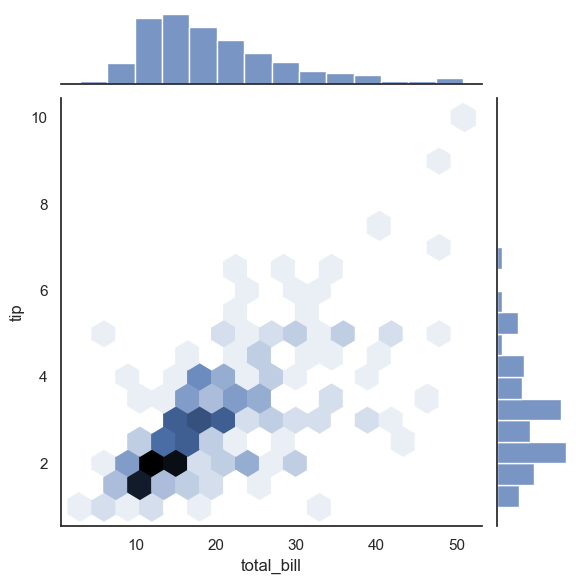

In [10]:
with sns.axes_style('white'):
    sns.jointplot(x="total_bill", y="tip", data=tips, kind='hex')

The joint plot can even do some automatic kernel density estimation and regression, as shown in the following figure:

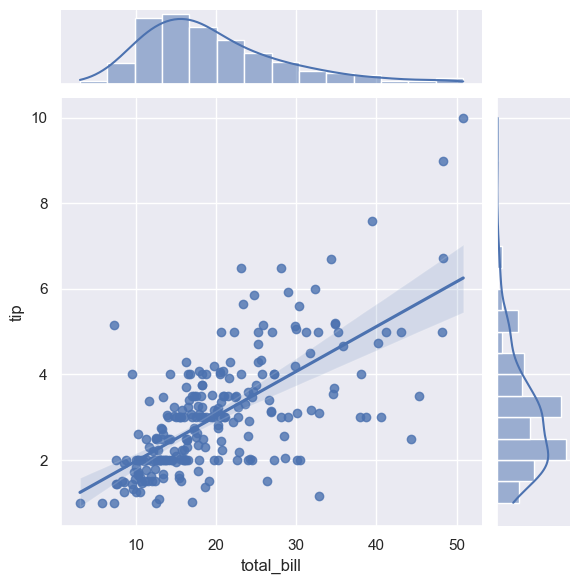

In [11]:
sns.jointplot(x="total_bill", y="tip", data=tips, kind='reg');

### Bar Plots

Time series can be plotted using `sns.factorplot`. In the following example, we'll use the Planets dataset that we first saw in [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb); see the following figure for the result:

In [12]:
planets = sns.load_dataset('planets')
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


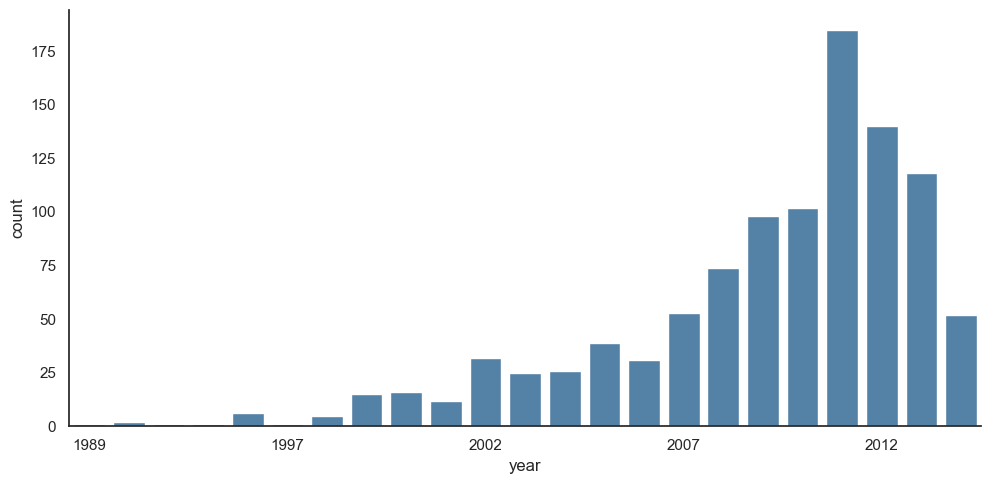

In [13]:
with sns.axes_style('white'):
    g = sns.catplot(x="year", data=planets, aspect=2,
                    kind="count", color='steelblue')
    g.set_xticklabels(step=5)

We can learn more by looking at the *method* of discovery of each of these planets (see the following figure):

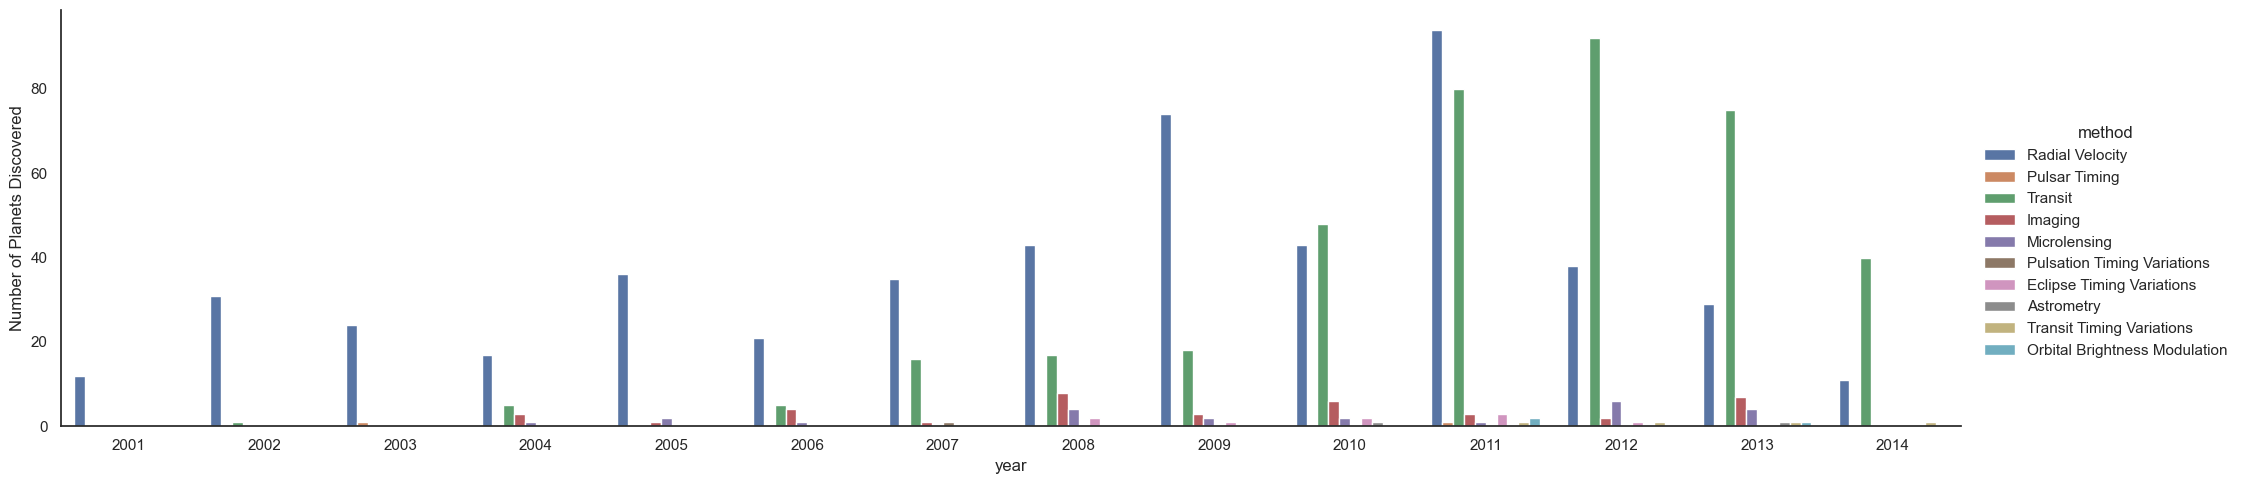

In [14]:
with sns.axes_style('white'):
    g = sns.catplot(x="year", data=planets, aspect=4.0, kind='count',
                    hue='method', order=range(2001, 2015))
    g.set_ylabels('Number of Planets Discovered')

For more information on plotting with Seaborn, see the [Seaborn documentation](http://seaborn.pydata.org/), and particularly the [example gallery](https://seaborn.pydata.org/examples/index.html).

## Example: Exploring Marathon Finishing Times

Here we'll look at using Seaborn to help visualize and understand finishing results from a marathon.
I've scraped the data from sources on the web, aggregated it and removed any identifying information, and put it on GitHub, where it can be downloaded
(if you are interested in using Python for web scraping, I would recommend [*Web Scraping with Python*](http://shop.oreilly.com/product/0636920034391.do) by Ryan Mitchell, also from O'Reilly).
We will start by downloading the data and loading it into Pandas:[^2]

[^2]: The marathon data used in this section divides runners into two genders: men and women. While gender is a
spectrum, the following discussion and visualizations use this binary because they depend on the data.

In [ ]:
# url = ('https://raw.githubusercontent.com/jakevdp/'
#        'marathon-data/master/marathon-data.csv')
# !cd data && curl -O {url}

In [ ]:
data = pd.read_csv('data/marathon-data.csv')
data.head()

Notice that Pandas loaded the time columns as Python strings (type `object`); we can see this by looking at the `dtypes` attribute of the `DataFrame`:

In [ ]:
data.dtypes

Let's fix this by providing a converter for the times:

In [ ]:
import datetime

def convert_time(s):
    h, m, s = map(int, s.split(':'))
    return datetime.timedelta(hours=h, minutes=m, seconds=s)

data = pd.read_csv('data/marathon-data.csv',
                   converters={'split':convert_time, 'final':convert_time})
data.head()

In [ ]:
data.dtypes

That will make it easier to manipulate the temporal data. For the purpose of our Seaborn plotting utilities, let's next add columns that give the times in seconds:

In [ ]:
data['split_sec'] = data['split'].view(int) / 1E9
data['final_sec'] = data['final'].view(int) / 1E9
data.head()

To get an idea of what the data looks like, we can plot a `jointplot` over the data; the following figure shows the result:

In [ ]:
with sns.axes_style('white'):
    g = sns.jointplot(x='split_sec', y='final_sec', data=data, kind='hex')
    g.ax_joint.plot(np.linspace(4000, 16000),
                    np.linspace(8000, 32000), ':k')

The dotted line shows where someone's time would lie if they ran the marathon at a perfectly steady pace. The fact that the distribution lies above this indicates (as you might expect) that most people slow down over the course of the marathon.
If you have run competitively, you'll know that those who do the opposite—run faster during the second half of the race—are said to have "negative-split" the race.

Let's create another column in the data, the split fraction, which measures the degree to which each runner negative-splits or positive-splits the race:

In [ ]:
data['split_frac'] = 1 - 2 * data['split_sec'] / data['final_sec']
data.head()

Where this split difference is less than zero, the person negative-split the race by that fraction.
Let's do a distribution plot of this split fraction (see the following figure):

In [ ]:
sns.displot(data['split_frac'], kde=False)
plt.axvline(0, color="k", linestyle="--");

In [ ]:
sum(data.split_frac < 0)

Out of nearly 40,000 participants, there were only 250 people who negative-split their marathon.

Let's see whether there is any correlation between this split fraction and other variables. We'll do this using a `PairGrid`, which draws plots of all these correlations (see the following figure):

In [ ]:
g = sns.PairGrid(data, vars=['age', 'split_sec', 'final_sec', 'split_frac'],
                 hue='gender', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

It looks like the split fraction does not correlate particularly with age, but does correlate with the final time: faster runners tend to have closer to even splits on their marathon time. Let's zoom in on the histogram of split fractions separated by gender, shown in the following figure:

In [ ]:
sns.kdeplot(data.split_frac[data.gender=='M'], label='men', shade=True)
sns.kdeplot(data.split_frac[data.gender=='W'], label='women', shade=True)
plt.xlabel('split_frac');

The interesting thing here is that there are many more men than women who are running close to an even split!
It almost looks like a bimodal distribution among the men and women. Let's see if we can suss out what's going on by looking at the distributions as a function of age.

A nice way to compare distributions is to use a *violin plot*, shown in the following figure:

In [ ]:
sns.violinplot(x="gender", y="split_frac", data=data,
               palette=["lightblue", "lightpink"]);

Let's look a little deeper, and compare these violin plots as a function of age (see the following figure). We'll start by creating a new column in the array that specifies the age range that each person is in, by decade:

In [ ]:
data['age_dec'] = data.age.map(lambda age: 10 * (age // 10))
data.head()

In [ ]:
men = (data.gender == 'M')
women = (data.gender == 'W')

with sns.axes_style(style=None):
    sns.violinplot(x="age_dec", y="split_frac", hue="gender", data=data,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"]);

We can see where the distributions among men and women differ: the split distributions of men in their 20s to 50s show a pronounced overdensity toward lower splits when compared to women of the same age (or of any age, for that matter).

Also surprisingly, it appears that the 80-year-old women seem to outperform *everyone* in terms of their split time, although this is likely a small number effect, as there are only a handful of runners in that range:

In [ ]:
(data.age > 80).sum()

Back to the men with negative splits: who are these runners? Does this split fraction correlate with finishing quickly? We can plot this very easily. We'll use `regplot`, which will automatically fit a linear regression model to the data (see the following figure):

In [ ]:
g = sns.lmplot(x='final_sec', y='split_frac', col='gender', data=data,
               markers=".", scatter_kws=dict(color='c'))
g.map(plt.axhline, y=0.0, color="k", ls=":");

Apparently, among both men and women, the people with fast splits tend to be faster runners who are finishing within ~15,000 seconds, or about 4 hours. People slower than that are much less likely to have a fast second split.